In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [129]:
#prices

fuels = pd.read_csv('fuels.csv')
cap = pd.read_csv('cap.csv')

In [130]:
dam = pd.read_csv('dam.csv')

dam['Date'] = pd.to_datetime(dam['Date'])

dam = (dam
       .set_index(dam['Date']) # pd.to_datetime(dam['Date'])
       .drop('Date', axis = 1)
       )

dam = dam.reset_index().rename(columns = {'Date': 'date_old'})
dam['date_new'] = dam['date_old'] - pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)

dam = dam.drop('date_old', axis = 1).rename(columns = {'date_new': 'Date'}).set_index('Date')

dam.columns = ['nyca_dam', 'nyc_dam', 'li_dam', 'gj_dam']

In [131]:
fuels = (fuels
         .set_index(pd.to_datetime(fuels['Date']))
         .drop('Date', axis = 1)
        )

In [132]:
cap = (cap
       .set_index(pd.to_datetime(cap['Date'], format = '%b-%y'))
       .drop('Date', axis = 1)
       )
cap.columns = ['nyca_icap', 'gj_icap', 'nyc_icap', 'li_icap']

In [133]:
locs = ['GJ', 'LI', 'NYC']

gen = {}

for loc in locs:
    gen[loc] = pd.read_csv(f'../data\Generating_Capacity_{loc}_11-23.csv')
    gen[loc] = (gen[loc]
                .set_index(pd.to_datetime(gen[loc]['Date']))
                .drop('Date', axis = 1))

gen['NYCA'] = pd.read_csv('../data\Generating_Capacity_NYCA_04-23.csv')
gen['NYCA'] = (gen['NYCA']
               .set_index(pd.to_datetime(gen['NYCA']['Date']))
               .drop('Date', axis = 1))

In [150]:
ucap = pd.read_csv("../data/Monthly_UCAP_Requirements.csv")
ucap = (ucap
        .set_index(pd.to_datetime(ucap['Date']))
        .drop('Date', axis = 1)
        )

In [155]:
above = pd.read_csv('../data/Monthly_Percent_Cleared_Above.csv')
above = (above
        .set_index(pd.to_datetime(above['Date']))
        .drop('Date', axis = 1)
        )

In [156]:
reg = (gen['NYCA']
       .join(cap)
       .join(fuels)
       .join(dam)
       .join(above)
       .join(ucap)
       .dropna(axis = 0)
       )

In [158]:
reg.columns

Index(['Gas (NYCA)', 'Coal (NYCA)', 'Oil (NYCA)', 'Renewables (NYCA)',
       'Others (NYCA)', 'Sum (NYCA)', 'nyca_icap', 'gj_icap', 'nyc_icap',
       'li_icap', 'coal', 'petroleum', 'natural gas', 'nyca_dam', 'nyc_dam',
       'li_dam', 'gj_dam', 'Cleared Above NYCA (%)', 'Cleared Above GJ (%)',
       'Cleared Above NYC (%)', 'Cleared Above LI (%)', 'UCAP NYCA (MW)',
       'UCAP GJ (MW)', 'UCAP NYC (MW)', 'UCAP LI (MW)'],
      dtype='object')

In [136]:
import statsmodels.api as sm

In [160]:
df = reg[['Gas (NYCA)', 
          'Coal (NYCA)', 'Oil (NYCA)', 'Renewables (NYCA)', 'Others (NYCA)', 
          'nyca_icap', 'natural gas', 'nyca_dam', 
          'Cleared Above NYCA (%)', 'UCAP NYCA (MW)']]

C:\Users\borve\AppData\Local\Temp\ipykernel_18700\3028576344.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True)


<AxesSubplot:>

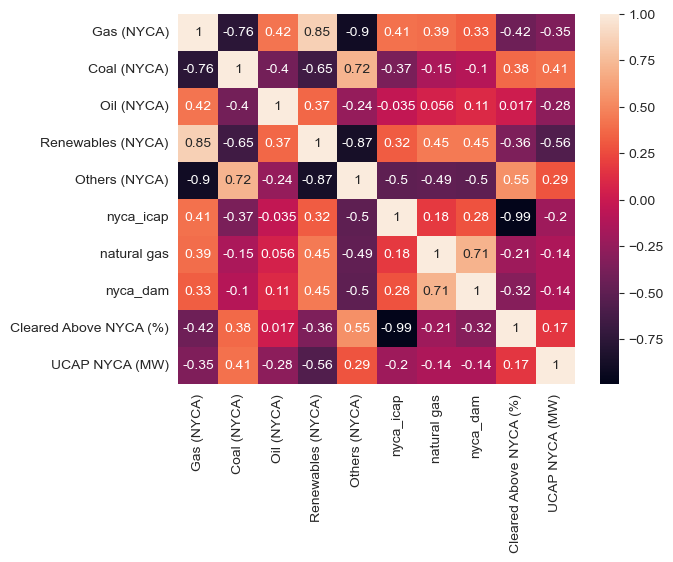

In [174]:
sns.heatmap(df.corr(), annot = True)

In [161]:
x = df.loc[:, df.columns != 'Gas (NYCA)']
y = df['Gas (NYCA)']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Gas (NYCA)   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     78.43
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           4.56e-32
Time:                        13:40:31   Log-Likelihood:                -527.13
No. Observations:                  77   AIC:                             1074.
Df Residuals:                      67   BIC:                             1098.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -901